In [3]:
!pip install networkx
!pip install matplotlib
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations, groupby

## Generating graph

In [5]:
# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

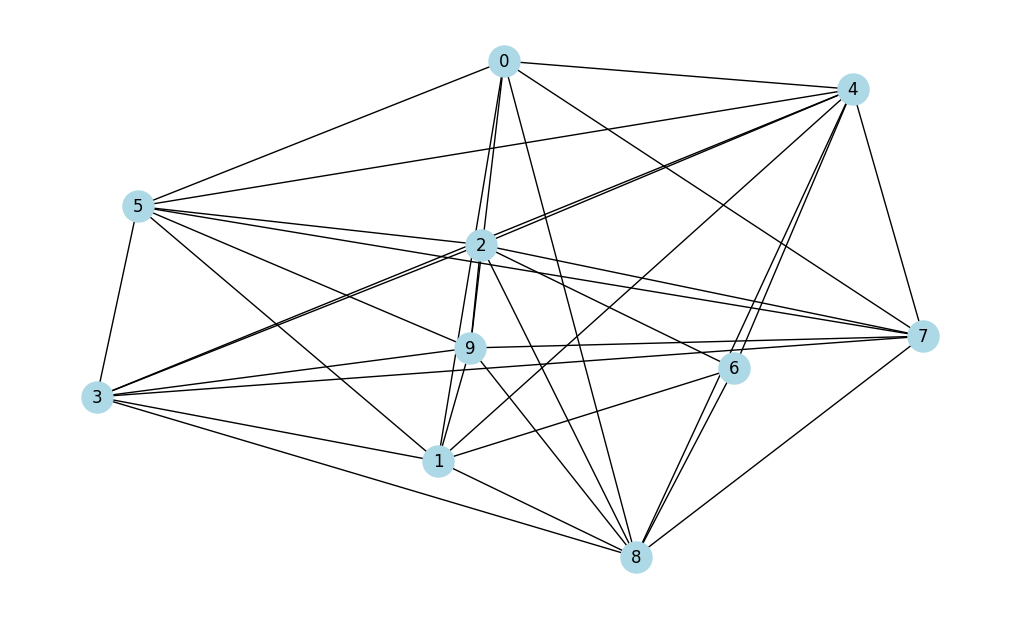

In [6]:
G = gnp_random_connected_graph(10, 0.7, False, True)

# Minimum spanning trees algorithms 

## Kruskal's algorithm

In [7]:
from networkx.algorithms import tree

In [8]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

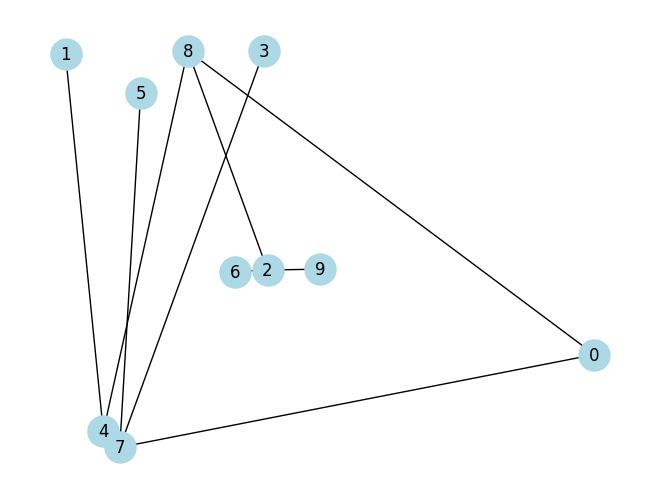

In [9]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [10]:
mstk.edges(), len(mstk.edges())

(EdgeView([(0, 7), (0, 8), (1, 4), (2, 8), (2, 9), (2, 6), (3, 7), (4, 8), (5, 7)]),
 9)

In [150]:

def kruskal(G):
    """
    Realisation of Kruskal's algorithm to find minimal spanning 
    tree of graph G 
    """
    edges = [ ((edge[0], edge[1]), edge[2]['weight']) for edge in G.edges(data=True)]
    edges.sort(key=lambda x: x[1])

    mst_edges = []
    partitioning = { node: {node} for node in G.nodes }

    for edge in edges:
        (u, v), weight = edge
        u_set = partitioning[u]
        v_set = partitioning[v]
        if v_set != u_set:
            mst_edges.append((u, v, weight))
            u_set |= v_set
            for w in u_set:
                partitioning[w] = u_set
            

    mst = nx.Graph()
    mst.add_weighted_edges_from(mst_edges)

    return mst

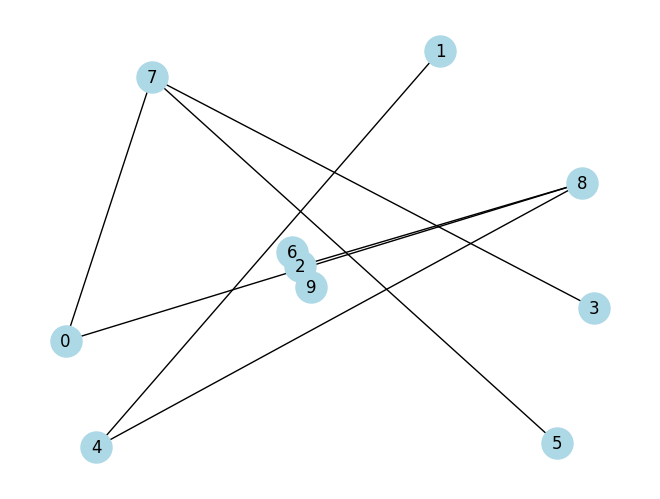

In [151]:
mstk_r = kruskal(G)

nx.draw(mstk_r, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

## Prim's algorithm

In [13]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

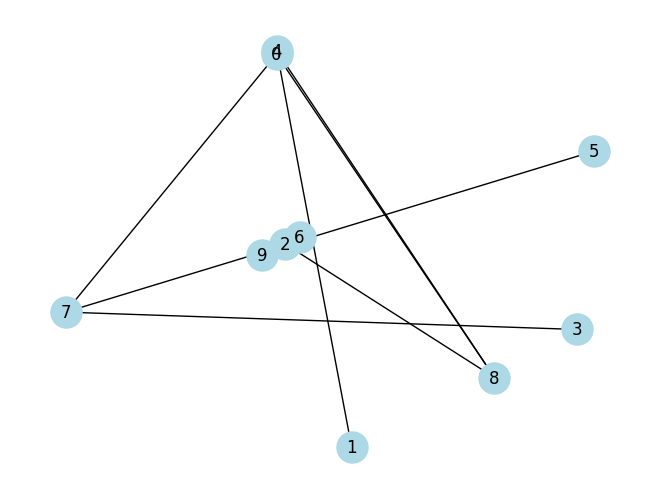

In [14]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [15]:
mstp.edges(), len(mstp.edges())
mstp.size(weight="weight")

-3.0

In [109]:
from heapq import heappop, heappush, heapify

def prim_mst(G):
    """
    Find minimum spannint tree using Prim's algorithm.
    """

    fronteer = list( (w['weight'], (u, v))  for u, v, w in G.edges(0, data=True))
    heapify(fronteer)
    nodes = {0}
    edges = set()

    edge_history = set()

    while fronteer:

        if len(nodes) == len(G):
            break
        
        w, (u, v) = heappop(fronteer)

        edge_history.add((u, v))

        if not v in nodes:
            nodes.add(v)
            edges.add((u, v, w))
            
        for v, w, weight in G.edges(v, data=True):
            if w not in nodes and (v, w) not in edge_history:     
                heappush(fronteer, ((weight['weight'], (v, w))))

    mst = nx.Graph()
    mst.add_weighted_edges_from(edges)     
    return mst



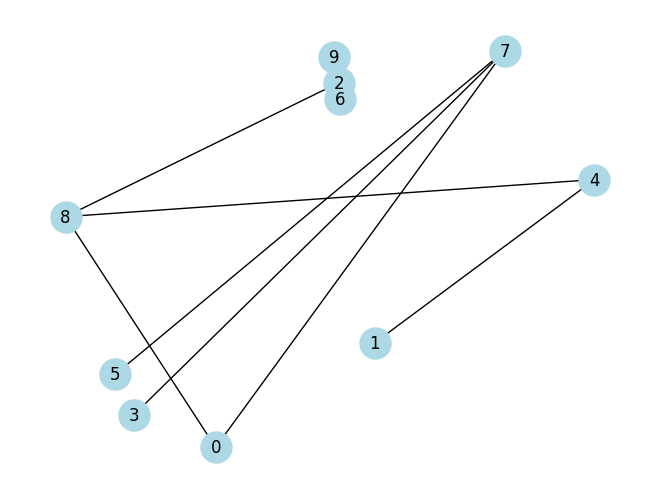

In [110]:
mstp_r = prim_mst(G)
nx.draw(mstp_r, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [18]:
mstp_r.edges(), len(mstp_r.edges())
mstp_r.size(weight="weight")

9.0

## Testing

### 1. Testing correctness
Firstly, we must test if:
1. our algorithms return a tree that contain all edges of the original graph
2. if this is tree but not forest
3. if weight of tree produced by implemented algorithm is less or equal to networkx implementation

In [111]:

def test(networkx_algorithm_name: str, my_realization: callable):

    for n in range(1, 11):
        n = 2 ** n
        print(">>> Graph size:", n)
        for j in range(1, 5):
            G = gnp_random_connected_graph(n, 1 / j, False, False)
            mst = nx.minimum_spanning_tree(G, algorithm=networkx_algorithm_name)
            mst_r = my_realization(G)

            assert nx.is_tree(mst_r)
            assert set(G.nodes) == set(mst.nodes)
            assert nx.number_connected_components(G) == 1
            assert mst.size(weight="weight") >= mst_r.size(weight="weight")



In [156]:
print("Test Kruskal implementation")
test("kruskal", kruskal)
print("Test prim implementation")
test("prim", prim_mst)

Test Kruskal implementation
>>> Graph size: 2
>>> Graph size: 4
>>> Graph size: 8
>>> Graph size: 16
>>> Graph size: 32
>>> Graph size: 64
>>> Graph size: 128
>>> Graph size: 256
>>> Graph size: 512
>>> Graph size: 1024
Test prim implementation
>>> Graph size: 2
>>> Graph size: 4
>>> Graph size: 8
>>> Graph size: 16
>>> Graph size: 32
>>> Graph size: 64
>>> Graph size: 128
>>> Graph size: 256
>>> Graph size: 512
>>> Graph size: 1024


### Time tests

In [51]:
import time
def plot_time_size(algorithms: dict[str, callable], max_nodes: int, completeness: float, step: str):

    algorithms_performance = { algorithm: [] for algorithm in algorithms}

    x = list(range(1, max_nodes+1, step))

    for i in x:
        g = gnp_random_connected_graph(i, completeness, False, False)

        for algorithm, algorithm_function in algorithms.items():
            start = time.perf_counter()
            algorithm_function(g)
            end = time.perf_counter()
            algorithms_performance[algorithm].append(end-start)

    for algorithm, performance in algorithms_performance.items():
        plt.plot(x, performance, label=algorithm)
    plt.legend()

    plt.show()


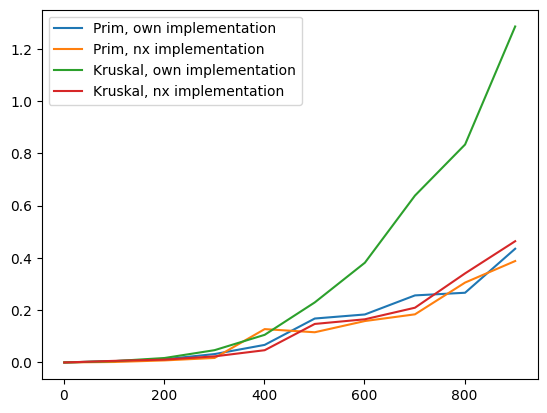

In [155]:
algorithms = {
    'Prim, own implementation': prim_mst,
    "Prim, nx implementation": lambda g: tree.minimum_spanning_tree(g, algorithm="prim"),
    "Kruskal, own implementation": kruskal,
    "Kruskal, nx implementation": lambda g: tree.minimum_spanning_tree(g, algorithm="kruskal")
}

plot_time_size(algorithms, 1000, 0.5, 100)